# 20. Transfer Learning with Inception v3

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import models
import torchvision.utils
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import numpy as np

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

## 20.1 Prepare Data

In [3]:
# https://pytorch.org/docs/stable/torchvision/models.html
# https://github.com/pytorch/vision/tree/master/torchvision/models
# 미리 사용할 모델의 Input 파악 필수!

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(299),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), # ToTensor : [0, 255] -> [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_data = dsets.ImageFolder('data/squir_chip_data/train/', train_transform)
test_data = dsets.ImageFolder('data/squir_chip_data/val/', test_transform)

In [4]:
batch_size = 5

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(test_data, 
                         batch_size=batch_size,
                         shuffle=True)

In [5]:
def imshow(img, title):
    img = torchvision.utils.make_grid(img, normalize=True)
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

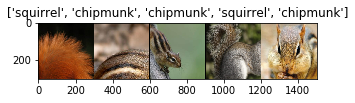

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(images, [train_data.classes[i] for i in labels])

## 20.2 Define Model

In [ ]:
model = models.inception_v3(pretrained=True)

In [ ]:
model

In [ ]:
model.aux_logits = False

for parameter in model.parameters():
    parameter.requires_grad = False

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 10),
    nn.Linear(10, 2)
)

In [ ]:
model = model.cuda()

In [ ]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

## 20.3 Train Model

In [ ]:
num_epochs = 30

In [ ]:
for epoch in range(num_epochs):
    
    total_batch = len(train_data)//batch_size

    for i, (batch_images, batch_labels) in enumerate(train_loader):
        
        X = batch_images.cuda()
        Y = batch_labels.cuda()

        pre = model(X)
        cost = loss(pre, Y)

        optimizer.zero_grad()
        cost.backward()
        optimizer.step()

        if (i+1) % 5 == 0:
            print('Epoch [%d/%d], lter [%d/%d] Loss: %.4f'
                 %(epoch+1, num_epochs, i+1, total_batch, cost.item()))

## 20.4 Test Model

In [ ]:
model.eval()

correct = 0
total = 0

for images, labels in test_loader:
    
    images = images.cuda()
    outputs = model(images)
    
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
    
print('Accuracy of test images: %f %%' % (100 * float(correct) / total))

In [ ]:
classes = ["Squirrel", "Chipmunk"]

In [ ]:
images, labels = iter(test_loader).next()

outputs = model(images.cuda())

_, predicted = torch.max(outputs.data, 1)
    
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(5)))

title = (' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images, normalize=True), title)